In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from PIL import Image
import pandas as pd

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

# imgroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img2/'
# tgtroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img2/'
tgtroot = 'C:/Users/lezhi/Dropbox/thesis/img/'

# building visual entropy in ALL images

In [51]:
cat_labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]

# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):    
    inds = [cat_labels.index(c)+243 for c in kwargs['category']] 
    # print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)

In [106]:
def iter_dir(rootdir, dostuff):
    emptyfiles = [] 
    
    citynames = sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)])
    for cityname in citynames[1:2]:   ######################
        # print cityname
        citypath = rootdir + cityname
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
        
        lat_lng_dir = np.array([name.replace('_',',').split(',') for name in imgnames])
        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng', 'dir']).astype(str) ########################
        df1['city'] = cityname
        
        records = []
    
        for i in range(len(imgnames)): 
            img_filepath = citypath + "/" + imgnames[i] + ".png"
            if os.stat(img_filepath).st_size > 0:                
                image = Image.open(img_filepath) 
                records = records + [dostuff(image)]
            else:
                emptyfiles.append(cityname + "/" + imgnames[i] + ".txt")
        #print records        
        
        df2 = pd.DataFrame(records, columns = ["entropy_mean", 'entropy_std']) # change this
                           
        df = pd.concat([df1, df2], axis=1)
        df.to_csv(rootdir+cityname+'_entropy'+'.csv') # change this
        
    np.savetxt('encode_empty_files'+'.txt', emptyfiles, fmt="%s")
    print str(len(emptyfiles)) + " files are empty"

In [103]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
def cal_entropy(im):
    greyIm=np.array(im.convert('L'))

    imarr = np.array(im)
    alpha = imarr[:, :, 3]
    #plt.imshow(alpha)
    
    mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
    if np.sum(mask) < 17280: ################### consider as no building
        return (np.nan, np.nan)
    else:
        base = (0*np.ones((360,480))).astype(np.uint8)
        base[mask] = greyIm[mask]    
        #plt.imshow(base)
        
        entM = entropy(mask, disk(3)) ######
        entB = entropy(base, disk(5)) ######

        return np.mean((entB-entM)[mask]), np.std((entB-entM)[mask])

In [105]:
ima = Image.open(tgtroot+'hongkong/22.278656,114.180662977_0.png')
cal_entropy(ima)

(4.9501602848204618, 0.77313100059958551)

In [ ]:
iter_dir(tgtroot, cal_entropy)

# building visual entropy in one image

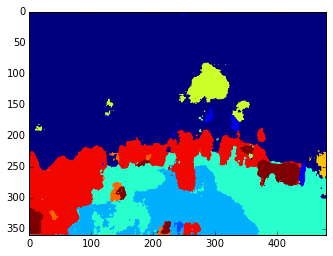

In [2]:
image = Image.open(tgtroot+'hongkong/22.278656,114.180662977_0.png') 
#  42.300131,-71.10339107_3  22.259156,114.200118326_1.png  22.266656,114.187148093_2.png  22.277156,114.170935302_1.png
# 22.278656,114.180662977_2  22.278656,114.166071465_0  22.278656,114.180662977_0  51.45386,-0.116771329008_1
# 51.45386,-0.138461068985_3  51.46136,-0.0926716179225_2 51.46286,-0.12882118455_3  40.701783,-73.9829296278_3

imarr = np.array(image)
alpha = imarr[:, :, 3]
plt.imshow(alpha)

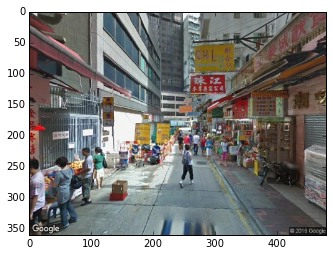

In [4]:
plt.imshow(image)

### method 1 (slow, not used)

In [5]:
# https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/basicFunctions.html#calculate-entropy-of-image
def entropy(signal):
    '''
    function returns entropy of a signal
    signal must be a 1-D numpy array
    '''
    lensig=signal.size
    symset=list(set(signal))
    numsym=len(symset)
    propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
    ent=np.sum([p*np.log2(1.0/p) for p in propab])
    return ent

In [6]:
colorIm=Image.open(tgtroot+'hongkong/22.278656,114.180662977_0.png')
greyIm=colorIm.convert('L')
colorIm=np.array(colorIm)
greyIm=np.array(greyIm)

In [7]:
N=5
S=greyIm.shape
E=np.array(greyIm)
for row in range(S[0]):
    for col in range(S[1]):
        Lx=np.max([0,col-N])
        Ux=np.min([S[1],col+N])
        Ly=np.max([0,row-N])
        Uy=np.min([S[0],row+N])
        region=greyIm[Ly:Uy,Lx:Ux].flatten()
        E[row,col]=entropy(region)

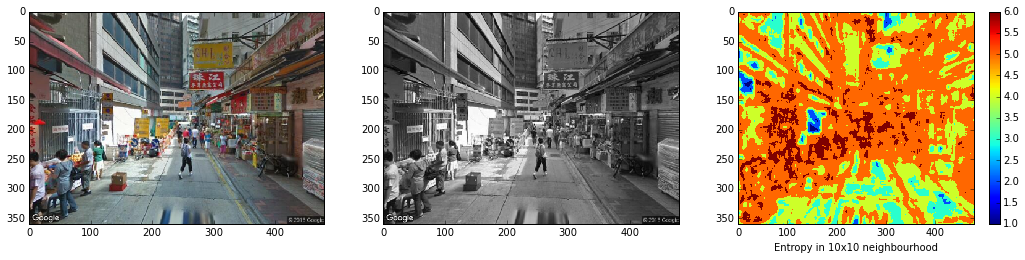

In [15]:
plt.figure(figsize=(18, 3.8))
plt.subplot(1,3,1)
plt.imshow(colorIm, interpolation='nearest', aspect='auto')

plt.subplot(1,3,2)
plt.imshow(greyIm, cmap=plt.cm.gray, interpolation='nearest', aspect='auto')

plt.subplot(1,3,3)
plt.imshow(E, cmap=plt.cm.jet, interpolation='nearest', aspect='auto')
plt.xlabel('Entropy in 10x10 neighbourhood')
plt.colorbar()

plt.show()

### method 2 (faster)

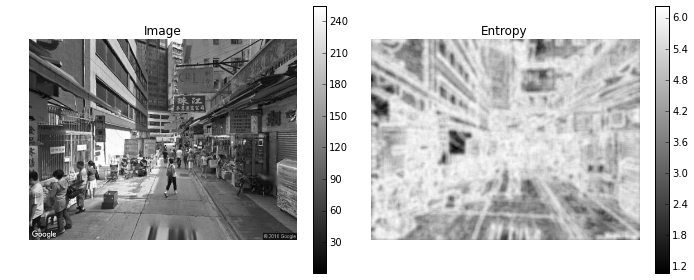

In [49]:
# http://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html
image = greyIm
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4), sharex=True,
                               sharey=True,
                               subplot_kw={"adjustable": "box-forced"})
img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(image, disk(5)), cmap=plt.cm.gray)
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()
plt.show()

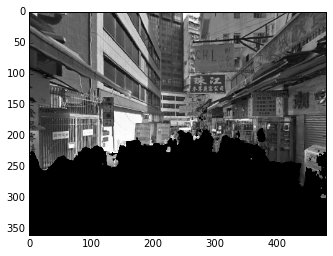

In [58]:
mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
base = (0*np.ones((360,480))).astype(np.uint8)
base[mask] = greyIm[mask]
plt.imshow(base, cmap=plt.cm.gray)

<matplotlib.colorbar.Colorbar instance at 0x000000002A7033C8>

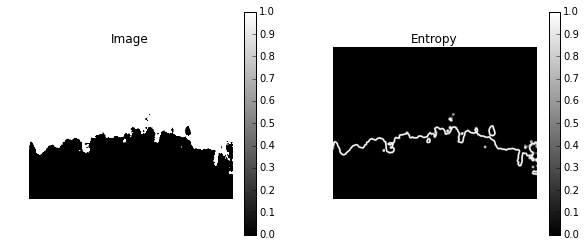

In [99]:
image = mask
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4), sharex=True,
                               sharey=True,
                               subplot_kw={"adjustable": "box-forced"})
img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

entM = entropy(image, disk(3))
img1 = ax1.imshow(entM, cmap=plt.cm.gray)
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

<matplotlib.colorbar.Colorbar instance at 0x000000002B076B08>

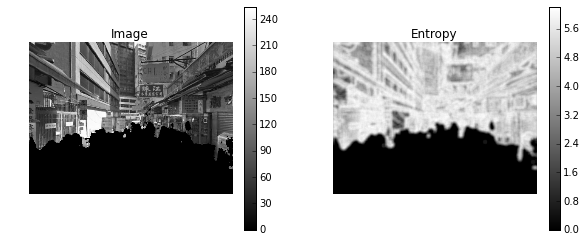

In [100]:
image = base
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4), sharex=True,
                               sharey=True,
                               subplot_kw={"adjustable": "box-forced"})
img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

entB = entropy(image, disk(5))
img1 = ax1.imshow(entB, cmap=plt.cm.gray)
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

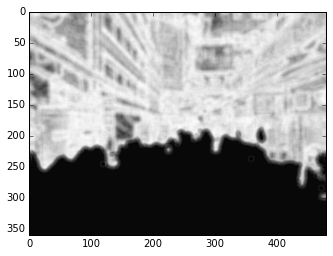

In [101]:
plt.imshow(entB - entM, cmap=plt.cm.gray)

In [102]:
# average entropy
print np.sum(entB) / np.sum(mask) , np.sum(entM), np.sum(entB-entM) / np.sum(mask)
print len((entB-entM)[mask])
# mean and std entropy
print "mean and std entropy:", np.mean((entB-entM)[mask]), np.std((entB-entM)[mask])

5.0503147276 4513.46726826 5.00826875227
107346
mean and std entropy: 4.95016028482 0.7731310006
